In [7]:
import numpy as np
import os
import trimesh
from trimesh.sample import sample_surface_sphere
from trimesh.ray.ray_pyembree import RayMeshIntersector
from shapely.geometry import LineString
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from open3d import *
%matplotlib inline

In [2]:
DATA_DIR = '../../../../data/ShapeNetCorev2/ShapeNetCore.v2/'
synsetId = '02691156'
modelId = 'afc2efb530e899634d4cb1c2a5e48b7a'

MODEL_DIR = os.path.join(DATA_DIR, synsetId, modelId, 'models')
STATS = os.path.join(MODEL_DIR, 'model_normalized.json')
MESH = os.path.join(MODEL_DIR, 'model_normalized.obj')
MATERIALS = os.path.join(MODEL_DIR, 'model_normalized.mtl')
FULL_VOXELS = os.path.join(MODEL_DIR, 'model_normalized.solid.binvox')
SURF_VOXELS = os.path.join(MODEL_DIR, 'model_normalized.surface.binvox')

In [3]:
mesh = trimesh.load_mesh(MESH)
mesh.show()

In [20]:
mesh.is_watertight

False

In [4]:
bounding_sphere = mesh.bounding_sphere
len(bounding_sphere.vertices)

642

In [8]:
class MeshSampler:
    def __init__(self, mesh):
        self.mesh = mesh
        self.sphere_points = trimesh.sample.sample_surface(mesh.bounding_sphere, count=1000)[0]*2
        self.correct_faces = {i:0 for i in range(len(mesh.faces))}
        self.ray_mesh = RayMeshIntersector(geometry=mesh)
        self.faces_centroids = self.mesh.triangles.mean(axis=1)
        self.correct_points = np.array([])
        
    def compute_visible_faces(self):
        for i, face in enumerate(tqdm(self.mesh.triangles)):
            for point in face:
                ray_directions = -(self.sphere_points - point)
                faces_hit = self.ray_mesh.intersects_first(self.sphere_points, ray_directions)
                if i in faces_hit:
                    self.correct_faces[i] = 1
        return self.correct_faces
    
    def sample_points(self, n_points=10000):
        points = trimesh.sample.sample_surface(self.mesh, count=n_points)
        correct_points = []
        for i, point in enumerate(tqdm(points[0])):
            if self.correct_faces[points[1][i]] == 1:
                correct_points += [point]
        self.correct_points = np.array(correct_points)
        return self.correct_points
    
    def perturb_points(self, sigma=0.05):
        pass

In [9]:
a = MeshSampler(mesh)

In [10]:
faces = a.compute_visible_faces()

In [19]:
print('All faces:', len(mesh.faces))
print('Visible faces:', sum(list(faces.values())))
print('Ratio of invisible faces:', (len(mesh.faces)-sum(list(faces.values())))/len(mesh.faces))

All faces: 74152
Visible faces: 72339
Ratio of invisible faces: 0.024449778832668034


In [13]:
points = a.sample_points(250000)

In [14]:
points = np.array(points)

In [15]:
len(points)

237922

In [16]:
point_cloud = trimesh.points.PointCloud(points)

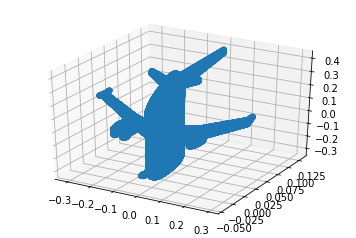

In [17]:
trimesh.points.plot_points(points)

In [18]:
pcd = PointCloud()
pcd.points = Vector3dVector(points)
write_point_cloud("./plane.ply", pcd)

True

In [ ]:
write_point_cloud("./plane.ply", pcd, )